In [192]:
import os
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.integrate import quad
from utils import generate_yyyymm, validate_uniqueness
import warnings
from scipy.optimize import fmin
from ipywidgets import *
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [60]:
# 환경설정
pd.set_option('mode.chained_assignment', None)
plt.style.use('default')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
if not any([s == 'result' for s in os.listdir('.')]): os.mkdir('result')
if not any([s == 'img' for s in os.listdir('.')]): os.mkdir('img')
warnings.filterwarnings('ignore')

In [4]:
# 데이터 불러오기
파일명 = 'Package Insurance Policy'
작업일자 = '20201029'
실적 = pd.read_excel(f'data/{파일명}_실적_{작업일자}.xlsx', dtype={'증권번호': str, '계약FY년월': str})
증권정보 = pd.read_excel(f'data/{파일명}_증권정보_{작업일자}.xlsx', dtype={'증권번호': str, 'POOL구분코드': str, '계약UY년월': str, '계약자고객번호': str, '회계처리자사원번호': str, '목적물코드': str, '상품코드': str})
섹션코드 = pd.read_excel('data/섹션코드.xlsx', dtype={'섹션코드': str}) \
    .loc[lambda x: x.섹션코드.isin(증권정보.섹션코드)]
목적물코드 = pd.read_excel('data/목적물코드.xlsx', dtype={'목적물코드': str}) \
    .loc[lambda x: x.목적물코드.isin(증권정보.목적물코드)]
물건구분코드 = pd.read_excel('data/물건구분코드.xlsx', dtype={'물건구분코드': str}) \
    .loc[lambda x: x.물건구분코드.isin(증권정보.대표물건구분코드)]
보험사코드 = pd.read_excel('data/보험사코드.xlsx', dtype={'보험사코드': str}) \
    .loc[lambda x: x.보험사코드.isin(증권정보.주관보험사코드)]
화재업종코드 = pd.read_excel('data/화재업종코드.xlsx', dtype={'화재업종코드': str}) \
    .loc[lambda x: x.화재업종코드.isin(증권정보.대표화재업종코드)]
공동인수구분코드 = pd.read_excel('data/공동인수구분코드.xlsx', dtype={'공동인수구분코드': str}) \
    .loc[lambda x: x.공동인수구분코드.isin(증권정보.공동인수구분코드)]
갱신구분코드 = pd.read_excel('data/갱신구분코드.xlsx', dtype={'갱신구분코드': str}) \
    .loc[lambda x: x.갱신구분코드.isin(증권정보.갱신구분코드)]
사업단번호 = pd.read_excel('data/사업단번호.xlsx', dtype={'사업단번호': str})
# 판단요율_증권번호 = pd.read_excel('data/판단요율_증권번호.xlsx', dtype={'증권번호': str})

In [5]:
# UY 및 FY 범위
uy_min = 증권정보.query('계약UY년월 != " "')['계약UY년월'].min()
uy_max = 증권정보.query('계약UY년월 != " "')['계약UY년월'].max()
fy_min = 실적['계약FY년월'].min()
fy_max = 실적['계약FY년월'].max()
print(f'UY: {uy_min} ~ {uy_max}')
print(f'FY: {fy_min} ~ {fy_max}')

UY: 200001 ~ 202009
FY: 200901 ~ 202009


In [6]:
# 변수 설정
FY시작년월, FY종료년월 = datetime(2015, 1, 1), datetime(2020, 9, 1)
UY시작년월, UY종료년월 = datetime(2015, 1, 1), datetime(2020, 9, 1)
UY년월 = pd.Series(generate_yyyymm((UY시작년월.year, UY시작년월.month), (UY종료년월.year, UY종료년월.month), 1))
FY년월 = pd.Series(generate_yyyymm((FY시작년월.year, FY시작년월.month), (FY종료년월.year, FY종료년월.month), 1))

In [7]:
# 증권정보 가공
증권정보_가공 = 증권정보.query('POOL구분코드 == " "').query('계약UY년월 >= @UY시작년월.strftime("%Y%m")')
증권정보_가공['보험기간시작일자'] = 증권정보_가공.groupby('증권번호')['보험기간시작일자'].max()[증권정보_가공.증권번호].values
증권정보_가공['보험기간종료일자'] = 증권정보_가공.groupby('증권번호')['보험기간종료일자'].max()[증권정보_가공.증권번호].values
증권정보_가공['계약자고객번호'] = 증권정보_가공.groupby('증권번호').apply(lambda x: x.sort_values(by=['회계일자', '계약확정일자']).tail(1)['계약자고객번호'].values[0])[증권정보_가공.증권번호].values
증권정보_가공['회계처리사업단번호'] = 증권정보_가공.groupby('증권번호').apply(lambda x: x.sort_values(by=['회계일자', '계약확정일자']).tail(1)['회계처리사업단번호'].values[0])[증권정보_가공.증권번호].values
증권정보_가공['총보험가입금액'] = 증권정보_가공.groupby('증권번호')['총보험가입금액'].max()[증권정보_가공.증권번호].values
증권정보_가공.loc[lambda x: x.증권번호 == "120150624638", "대표화재업종코드"] = "0231103"
증권정보_가공.loc[lambda x: x.증권번호 == "120160472328", "대표화재업종코드"] = "1242A03"
증권정보_가공.loc[lambda x: x.증권번호 == "120160643927", "대표화재업종코드"] = "1304002"
증권정보_가공.loc[lambda x: x.증권번호 == "120170458412", "대표화재업종코드"] = "0901002"
증권정보_가공.loc[lambda x: x.증권번호 == "120170789844", "대표화재업종코드"] = "0479D03"
증권정보_가공.loc[lambda x: x.증권번호 == "120170860962", "대표화재업종코드"] = "0451103"
증권정보_가공.loc[lambda x: x.증권번호 == "120170940571", "대표화재업종코드"] = "1292003"
증권정보_가공.loc[lambda x: x.증권번호 == "120180628352", "대표화재업종코드"] = "0801002"
증권정보_가공.loc[lambda x: x.증권번호 == "120190646774", "대표화재업종코드"] = "1022003"
증권정보_가공.loc[lambda x: x.증권번호 == "120190712993", "대표화재업종코드"] = "1401102"
증권정보_가공.loc[lambda x: x.증권번호 == "120150624638", "대표물건구분코드"] = "03"
증권정보_가공.loc[lambda x: x.증권번호 == "120170789844", "대표물건구분코드"] = "03"
증권정보_가공.loc[lambda x: x.증권번호 == "120170860962", "대표물건구분코드"] = "03"
증권정보_가공.loc[lambda x: x.증권번호 == "120160554882", "주관보험사코드"] = "10"
증권정보_가공.loc[lambda x: x.증권번호 == "120160647858", "주관보험사코드"] = "10"
증권정보_가공.loc[lambda x: x.증권번호 == "120160648148", '계약UY년월'] = "201606" # 계약FY년월 < 계약UY년월 수정
증권정보_가공 = 증권정보_가공[['증권번호', '상품코드', '계약UY년월', '총보험가입금액', '보험기간시작일자', '보험기간종료일자', '대표화재업종코드', '대표물건구분코드', '주관보험사코드', '공동인수율', '공동인수구분코드', '갱신구분코드', '계약자고객번호', '회계처리사업단번호']].drop_duplicates()
if not 증권정보_가공['증권번호'].is_unique: raise Exception('증권번호 유일성 오류')
증권정보_가공 = 증권정보_가공.assign(
    보험기간시작일자 = lambda x: pd.to_datetime(x.보험기간시작일자, format='%Y%m%d'),
    보험기간종료일자 = lambda x: pd.to_datetime(x.보험기간종료일자, format='%Y%m%d'),
    보험기간 = lambda x: (x.보험기간종료일자 - x.보험기간시작일자).apply(lambda x: x.days)
)

# validate_uniqueness(증권정보_가공, '증권번호', '보험기간시작일자')
# validate_uniqueness(증권정보_가공, '증권번호', '보험기간종료일자')
# validate_uniqueness(증권정보_가공, '증권번호', '계약UY년월')
# validate_uniqueness(증권정보_가공, '증권번호', '대표화재업종코드')
# validate_uniqueness(증권정보_가공, '증권번호', '대표물건구분코드')
# validate_uniqueness(증권정보_가공, '증권번호', '주관보험사코드')
# validate_uniqueness(증권정보_가공, '증권번호', '공동인수율')
# validate_uniqueness(증권정보_가공, '증권번호', '공동인수구분코드')
# validate_uniqueness(증권정보_가공, '증권번호', '갱신구분코드')
# validate_uniqueness(증권정보_가공, '증권번호', '계약자고객번호')
# validate_uniqueness(증권정보_가공, '증권번호', '회계처리사업단번호')
# validate_uniqueness(증권정보_가공, '증권번호', '총보험가입금액')

In [44]:
# 실적 가공
실적_가공 = 증권정보_가공.merge(실적, on='증권번호', how='left')
유효증권번호 = 실적_가공.groupby(['증권번호', '총보험가입금액'])['원수보험료'].sum() \
    .reset_index().query('원수보험료 > 0 and 총보험가입금액 > 0').증권번호.unique()
증권정보_유효 = 증권정보_가공.query('증권번호 in @유효증권번호')
증권정보_무효 = 증권정보_가공.query('증권번호 not in @유효증권번호')
실적_가공 = 실적_가공.query('증권번호 in @유효증권번호') \
    .merge(화재업종코드, left_on='대표화재업종코드', right_on='화재업종코드', how='left') \
    .merge(물건구분코드, left_on='대표물건구분코드', right_on='물건구분코드', how='left') \
    .merge(보험사코드, left_on='주관보험사코드', right_on='보험사코드', how='left') \
    .merge(공동인수구분코드, on='공동인수구분코드', how='left') \
    .merge(갱신구분코드, on='갱신구분코드', how='left') \
    .merge(목적물코드, on='목적물코드', how='left') \
    .merge(섹션코드, on='섹션코드', how='left') \
    .merge(사업단번호, left_on='회계처리사업단번호', right_on='사업단번호', how='left') \
    .assign(
        UY = lambda x: x.계약UY년월.str.slice(0, 4),
        FY = lambda x: x.계약FY년월.str.slice(0, 4),
        UY분기 = lambda x: "'" + x.계약UY년월.str.slice(2, 4) + "." + ((x.계약UY년월.str.slice(4, 6).astype(int)-1)//3+1).astype(str) + "Q",
        FY분기 = lambda x: "'" + x.계약FY년월.str.slice(2, 4) + "." + ((x.계약FY년월.str.slice(4, 6).astype(int)-1)//3+1).astype(str) + "Q",
        경과분기 = lambda x: 4*(x.계약FY년월.str.slice(2, 4).astype(int) - x.계약UY년월.str.slice(2, 4).astype(int))+((x.계약FY년월.str.slice(4, 6).astype(int)-1)//3+1)-((x.계약UY년월.str.slice(4, 6).astype(int)-1)//3+1),
        경과년도 = lambda x: x.계약FY년월.str.slice(2, 4).astype(int) - x.계약UY년월.str.slice(2, 4).astype(int),
        화재업종대분류명 = lambda x: x.화재업종대분류명.fillna('구분없음'),
        물건구분명 = lambda x: x.물건구분명.fillna('구분없음'),
        보험사명 = lambda x: x.보험사명.fillna('구분없음'),
        공동인수구분명 = lambda x: x.공동인수구분명.fillna('구분없음'),
        갱신구분명 = lambda x: x.갱신구분명.fillna('구분없음'),
        목적물명 = lambda x: x.목적물명.fillna('구분없음'),
        섹션명 = lambda x: x.섹션명.fillna('구분없음'),
        회계처리사업단명 = lambda x: x.조직사업단명.fillna('구분없음'),
        회계처리본부명 = lambda x: x.조직본부명.fillna('구분없음'),
        회계처리부문명 = lambda x: x.조직부문명.fillna('구분없음'),
        당사보험가입금액 = lambda x: x.총보험가입금액*x.공동인수율/100,
    ) \
    .drop(['대표화재업종코드', '대표물건구분코드', '주관보험사코드', '공동인수구분코드',
        '갱신구분코드', '회계처리사업단번호', '사업단번호', '보험사코드', '물건구분코드',
        '화재업종코드', '조직사업단명', '조직본부명', '조직부문명', '목적물코드', '섹션코드', '계약자고객번호'], axis=1)

In [9]:
# a = 실적_가공.groupby(['증권번호', '공동인수율', '당사보험가입금액', '총보험가입금액'])['원수보험료'].sum().reset_index() \
#     .eval('조정원수보험료 = 원수보험료/공동인수율') \
#     .eval('요율 = 원수보험료/당사보험가입금액*100') \
#     .sort_values(by='당사보험가입금액').reset_index(drop=True) \
#     .assign(누적건수 = lambda x: x.index + 1) \
#     .assign(누적원수보험료 = lambda x: x.원수보험료.cumsum())

대형물건기준 = lambda x: x.총보험가입금액 >= 1.2e12
소형물건기준 = lambda x: x.총보험가입금액 < 1.2e12
# 대형물건 = a.loc[대형물건기준]
# 소형물건 = a.loc[소형물건기준]

In [62]:
# 실적_가공.loc[대형물건기준].groupby('UY')[['원수보험료', '특약출재보험료', '원수경과보험료', '원수손해액', '특약출재경과보험료', '특약출재손해액', '특약출재수수료']].sum() \
#     .eval('원수손해율 = 원수손해액/원수경과보험료') \
#     .eval('특약출재율 = 특약출재보험료/원수보험료') \
#     .eval('특약출재손해율 = 특약출재손해액/특약출재경과보험료') \
#     .eval('특약출재수수료율 = 특약출재수수료/특약출재보험료') \
#     .eval('특약출재합산비율 = 특약출재손해율+특약출재수수료율')

In [11]:
j = 실적_가공.loc[대형물건기준].groupby('UY')[['원수보험료', '임의출재보험료', '원수경과보험료', '원수손해액', '임의출재경과보험료', '임의출재손해액', '임의출재수수료']].sum() \
    .eval('원수손해율 = 원수손해액/원수경과보험료') \
    .eval('임의출재율 = 임의출재보험료/원수보험료') \
    .eval('임의출재손해율 = 임의출재손해액/임의출재경과보험료') \
    .eval('임의출재수수료율 = 임의출재수수료/임의출재보험료') \
    .eval('임의출재합산비율 = 임의출재손해율+임의출재수수료율') \
    .eval('임의출재수지손 = 임의출재경과보험료*(1-임의출재합산비율)')

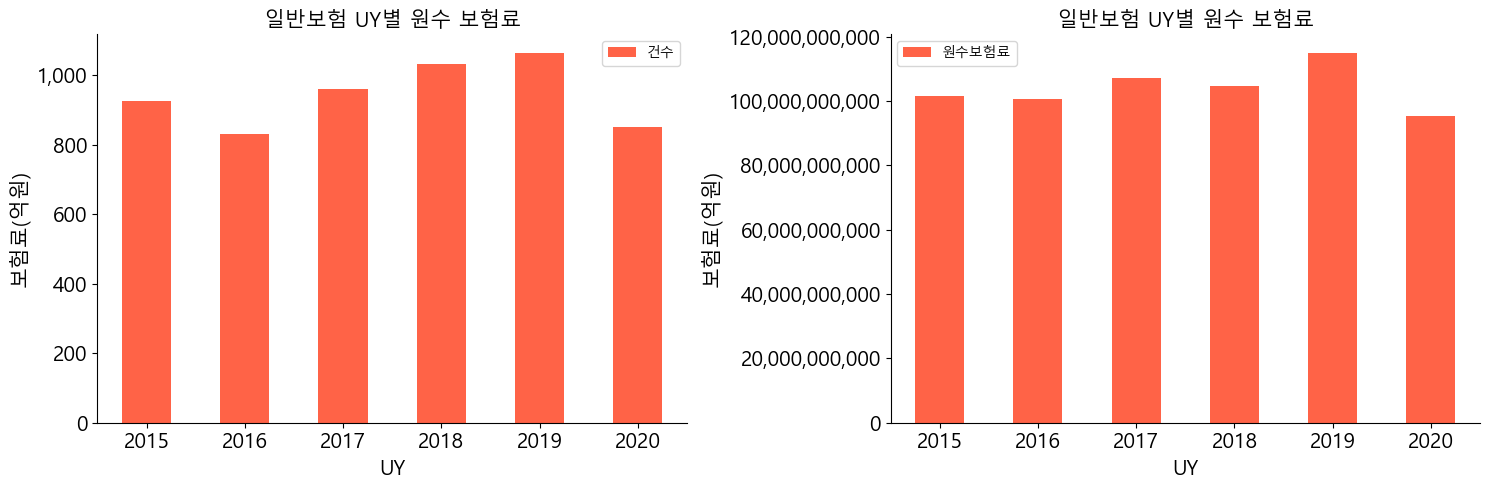

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df1 = 실적_가공.groupby(['증권번호', 'UY']).apply(lambda x: x['증권번호'].unique().shape[0]).reset_index(name='건수').groupby('UY')['건수'].sum()
df1.plot(kind='bar', ax=ax[0], color='tomato')
ax[0].legend()
ax[0].set_title('일반보험 UY별 원수 보험료', fontsize=15)
ax[0].set_xlabel('UY', fontsize=15)
ax[0].set_ylabel('보험료(억원)', fontsize=15)
ax[0].tick_params(rotation=0, labelsize=15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_yticks(np.arange(0, 1200, 200))
ax[0].yaxis.set_major_formatter(lambda x, _: f'{x:,.0f}')

df2 = 실적_가공.groupby(['증권번호', 'UY'])['원수보험료'].sum().reset_index().groupby('UY')['원수보험료'].sum()
df2.plot(kind='bar', ax=ax[1], color='tomato')
ax[1].legend()
ax[1].set_title('일반보험 UY별 원수 보험료', fontsize=15)
ax[1].set_xlabel('UY', fontsize=15)
ax[1].set_ylabel('보험료(억원)', fontsize=15)
ax[1].tick_params(rotation=0, labelsize=15)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# ax[1].set_yticks(np.arange(0, 1200, 200))
ax[1].yaxis.set_major_formatter(lambda x, _: f'{x:,.0f}')

plt.tight_layout()
# plt.savefig('img/매출')
plt.show()

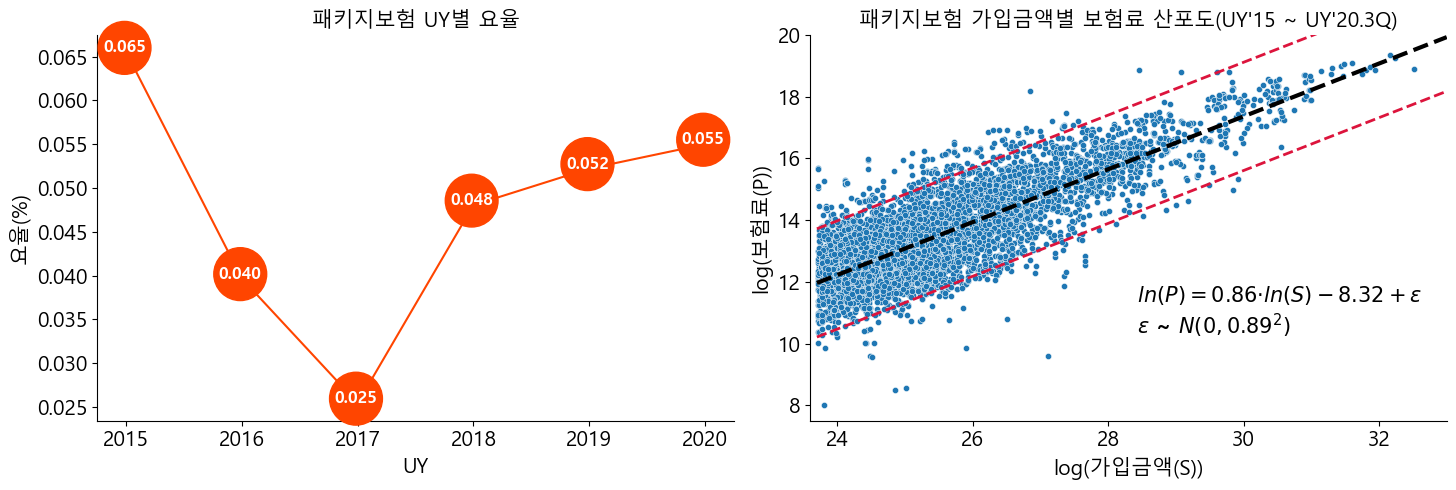

In [375]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df = 실적_가공.groupby(['증권번호', 'UY', '당사보험가입금액'])['원수보험료'].sum().reset_index() \
    .groupby('UY')[['원수보험료', '당사보험가입금액']].sum() \
    .eval('요율 = 원수보험료/당사보험가입금액*100')
df['요율'].plot(kind='line', marker='o', ax=ax[0], color='orangered')
ax[0].set_title('패키지보험 UY별 요율', fontsize=15)
ax[0].set_xlabel('UY', fontsize=15)
ax[0].set_ylabel('요율(%)', fontsize=15)
ax[0].tick_params(rotation=0, labelsize=15)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
for x in range(len(df)):
    ax[0].text(x-0.2, df['요율'][x], f'{df["요율"][x]:,.3f}', color='white', fontsize=12, fontweight='bold', bbox={'pad': 0.3, 'color': 'orangered', 'boxstyle': 'circle'})

df = 실적_가공.query('총보험가입금액 > 2e10').groupby(['증권번호', 'UY', '공동인수율', '당사보험가입금액', '총보험가입금액'])[['원수보험료', '원수경과보험료', '원수손해액', '임의출재보험료', '임의출재경과보험료', '임의출재손해액', '임의출재수수료']].sum().reset_index() \
        .eval('조정원수보험료 = 원수보험료/공동인수율') \
        .eval('요율 = 원수보험료/당사보험가입금액*100') \
        .assign(총보험가입금액_log = lambda x: np.log(x.총보험가입금액)) \
        .assign(조정원수보험료_log = lambda x: np.log(x.조정원수보험료))
sns.scatterplot(x='총보험가입금액_log', y='조정원수보험료_log', data=df, s=20, ax=ax[1])
X_train = sm.add_constant(df['총보험가입금액_log'])
y_train = df['조정원수보험료_log']
model = sm.OLS(y_train, X_train)
res = model.fit()
const, beta = res.params
sigma = res.mse_resid
X_pred = np.linspace(23.7, 33, 100)
y_pred = res.predict(sm.add_constant(np.linspace(23.7, 33, 100)))
plt.plot(X_pred, y_pred, color='black', alpha=1, linestyle='dashed', lw=3)
plt.plot(X_pred, y_pred+1.96*sigma, color='crimson', alpha=1, linestyle='dashed', lw=2)
plt.plot(X_pred, y_pred-1.96*sigma, color='crimson', alpha=1, linestyle='dashed', lw=2)
ax[1].set_title('패키지보험 가입금액별 보험료 산포도(UY\'15 ~ UY\'20.3Q)', fontsize=15)
ax[1].set_xlabel('log(가입금액(S))', fontsize=15)
ax[1].set_ylabel('log(보험료(P))', fontsize=15)
ax[1].tick_params(rotation=0, labelsize=15)
ax[1].set_xlim([23.6, 33])
ax[1].set_ylim([7.5, 20])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].text(28, 9.5, f"""
    $ln(P) = {beta:.2f}·ln(S) - {-const:.2f} + ε$\n\
    $\epsilon$ ~ $N(0, {sigma:,.2f}^2)$
""", size=15, weight='bold')
    
plt.tight_layout()
plt.savefig('img/요율')
plt.show()

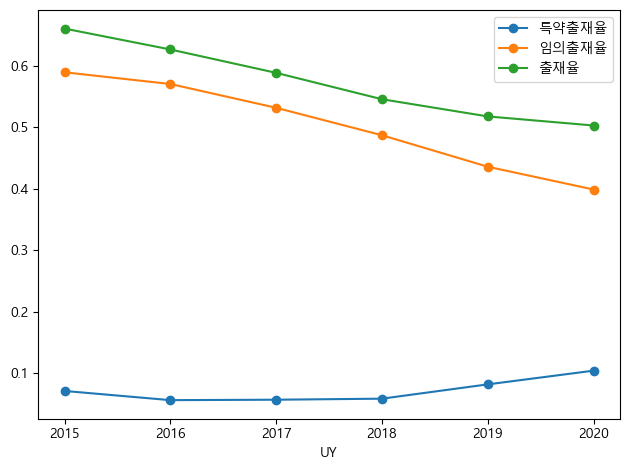

In [84]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df = 실적_가공.groupby(['UY'])[['원수보험료', '출재보험료', '임의출재보험료', '특약출재보험료']].sum() \
    .eval('출재율 = 출재보험료/원수보험료') \
    .eval('특약출재율 = 특약출재보험료/원수보험료') \
    .eval('임의출재율 = 임의출재보험료/원수보험료')
df['특약출재율'].plot(marker='o')
df['임의출재율'].plot(marker='o')
df['출재율'].plot(marker='o')
plt.legend()
plt.tight_layout()
plt.savefig('img/출재율')

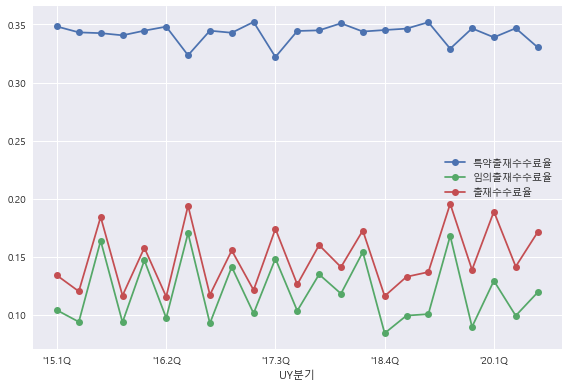

In [16]:
tmp = 실적_가공.groupby(['UY분기'])[['출재보험료', '임의출재보험료', '특약출재보험료', '출재수수료', '임의출재수수료', '특약출재수수료']].sum() \
    .eval('출재수수료율 = 출재수수료/출재보험료') \
    .eval('특약출재수수료율 = 특약출재수수료/특약출재보험료') \
    .eval('임의출재수수료율 = 임의출재수수료/임의출재보험료')
tmp['특약출재수수료율'].plot(marker='o')
tmp['임의출재수수료율'].plot(marker='o')
tmp['출재수수료율'].plot(marker='o')
plt.legend()
plt.tight_layout()
plt.savefig('img/출재수수료율')

In [18]:
@interact
def show(기준=IntSlider(value=1.2e12, step=1e11, max=2e13, min=1e11)):
    실적_가공['가입금액그룹'] = np.where(실적_가공['총보험가입금액'] < 기준, f'{int(기준/1e8):,.0f}억원이하', f'{int(기준/1e8):,.0f}억원초과')
    a = 실적_가공.loc[lambda x: x.UY분기.isin(['\'19.4Q', '\'20.1Q', '\'20.2Q'])] \
        .groupby('가입금액그룹') \
        [['총보험가입금액', '당사보험가입금액', '원수보험료', '원수경과보험료', '원수손해액',
          '출재보험료', '출재경과보험료', '출재손해액', '출재수수료',
          '특약출재보험료', '특약출재경과보험료', '특약출재손해액', '특약출재수수료',
          '임의출재보험료', '임의출재경과보험료', '임의출재손해액', '임의출재수수료']].sum()
    a.loc['합계'] = a.sum()
    a /= 1e8
    a = a.eval('공동인수율 = 당사보험가입금액/총보험가입금액')
    a = a.eval('원수손해율 = 원수손해액/원수경과보험료')
    a = a.eval('출재율 = 출재보험료/원수보험료')
    a = a.eval('출재손해율 = 출재손해액/출재경과보험료')
    a = a.eval('출재수수료율 = 출재수수료/출재보험료')
    a = a.eval('출재합산비율 = 출재손해율+출재수수료율')
    a = a.eval('특약출재율 = 특약출재보험료/원수보험료')
    a = a.eval('특약출재손해율 = 특약출재손해액/특약출재경과보험료')
    a = a.eval('특약출재수수료율 = 특약출재수수료/특약출재보험료')
    a = a.eval('특약출재합산비율 = 특약출재손해율+특약출재수수료율')
    a = a.eval('임의출재율 = 임의출재보험료/원수보험료')
    a = a.eval('임의출재손해율 = 임의출재손해액/임의출재경과보험료')
    a = a.eval('임의출재수수료율 = 임의출재수수료/임의출재보험료')
    a = a.eval('임의출재합산비율 = 임의출재손해율+임의출재수수료율')
#     a = a.eval('임의출재비중 = 임의출재보험료/출재보험료')
    a = a.drop(['총보험가입금액', '당사보험가입금액'], axis=1)
    display(a.T)

interactive(children=(IntSlider(value=1200000000000, description='기준', max=20000000000000, min=100000000000, s…

In [19]:
@interact
def show(지표=['원수보험료', '원수경과보험료', '원수손해액', '출재보험료', '출재경과보험료', '출재손해액'], 기준=IntSlider(value=1.2e12, step=1e11, max=2e12, min=1e11)):
    실적_가공['가입금액그룹'] = np.where(실적_가공['총보험가입금액'] < 기준, f'{int(기준/1e8)}억원이하', f'{int(기준/1e8)}억원초과')
    실적_가공 \
        .groupby('가입금액그룹')[['원수보험료', '원수경과보험료', '원수손해액', '출재보험료', '출재경과보험료', '출재손해액']].sum() \
        .plot(kind='pie', y=지표)

interactive(children=(Dropdown(description='지표', options=('원수보험료', '원수경과보험료', '원수손해액', '출재보험료', '출재경과보험료', '출재…

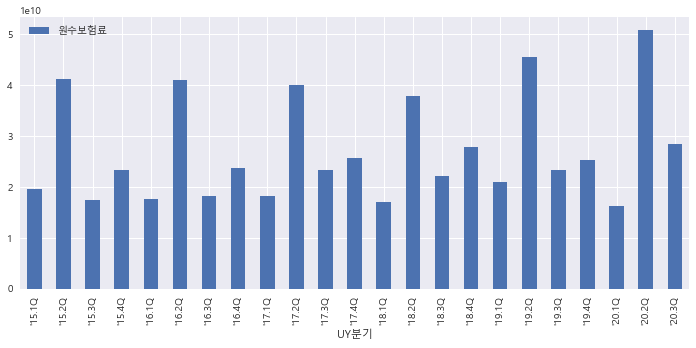

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
실적_가공.groupby('UY분기')[['원수보험료']].sum().plot(kind='bar', ax=ax)
plt.show()

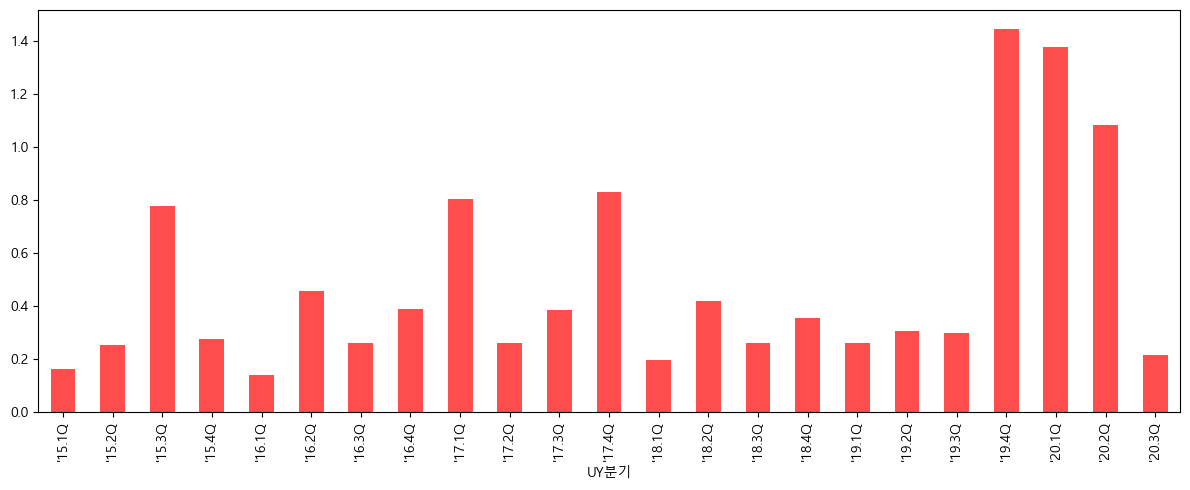

In [378]:
fig, ax = plt.subplots(figsize=(12, 5))

실적_가공.groupby('UY분기')[['원수보험료', '원수경과보험료', '원수손해액']].sum() \
    .eval('원수손해율 = 원수손해액/원수경과보험료') \
    [['원수손해율']] \
    .plot(kind='bar', ax=ax, color='red', alpha=0.7, legend=None)
plt.tight_layout()
plt.savefig('img/원수손해율')
plt.show()

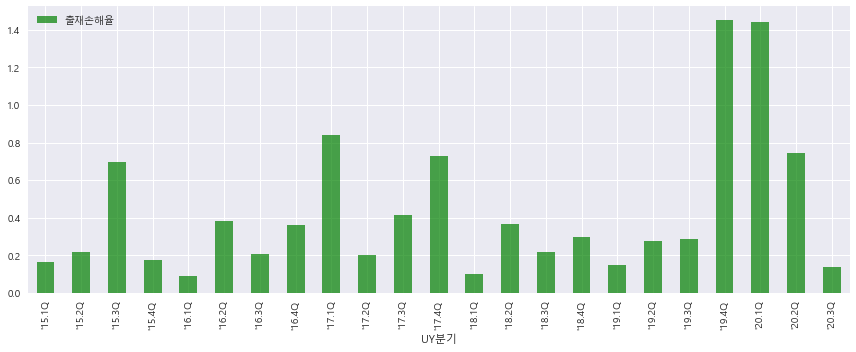

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
실적_가공.groupby('UY분기')[['출재보험료', '출재경과보험료', '출재손해액']].sum() \
    .eval('출재손해율 = 출재손해액/출재경과보험료') \
    [['출재손해율']] \
    .plot(kind='bar', ax=ax, color='green', alpha=0.7)
plt.tight_layout()
plt.savefig('img/출재손해율')
plt.show()

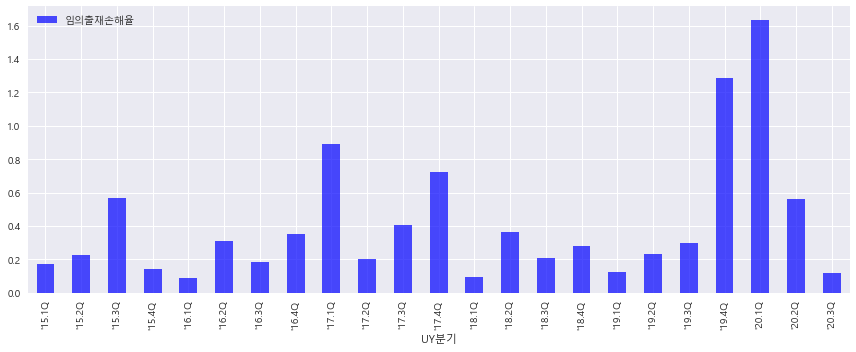

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
실적_가공.groupby('UY분기')[['임의출재보험료', '임의출재경과보험료', '임의출재손해액']].sum() \
    .eval('임의출재손해율 = 임의출재손해액/임의출재경과보험료') \
    [['임의출재손해율']] \
    .plot(kind='bar', ax=ax, color='blue', alpha=0.7)
plt.tight_layout()
plt.savefig('img/임의출재손해율')
plt.show()

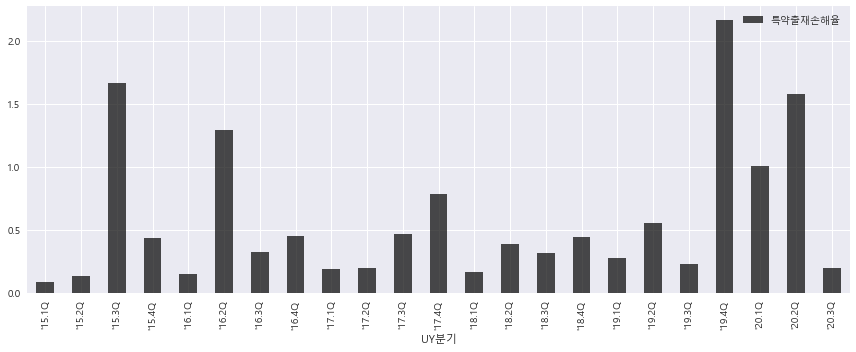

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))
실적_가공.groupby('UY분기')[['특약출재보험료', '특약출재경과보험료', '특약출재손해액']].sum() \
    .eval('특약출재손해율 = 특약출재손해액/특약출재경과보험료') \
    [['특약출재손해율']] \
    .plot(kind='bar', ax=ax, color='black', alpha=0.7)
plt.tight_layout()
plt.savefig('img/특약출재손해율')
plt.show()

In [382]:
@interact
def show(지표=['원수보험료', '원수경과보험료', '원수손해액']):
    기준 = 1.2e12
    실적_가공['가입금액그룹'] = np.where(실적_가공['총보험가입금액'] < 기준, f'{int(기준/1e8)}억원이하', f'{int(기준/1e8)}억원초과')
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    실적_가공.groupby('물건구분명')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[0][0])

    실적_가공.groupby('화재업종대분류명')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[0][1])

    실적_가공.groupby('보험사명')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[0][2])

    실적_가공.groupby('공동인수구분명')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[1][0])
    
    실적_가공.groupby('갱신구분명')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[1][1])
    
    실적_가공.groupby('가입금액그룹')[[지표]].sum() \
        .plot(kind='pie', y=지표, ax=ax[1][2])

    plt.tight_layout()
    plt.savefig('img/특성별')
    plt.show()

interactive(children=(Dropdown(description='지표', options=('원수보험료', '원수경과보험료', '원수손해액'), value='원수보험료'), Output…

In [26]:
@interact
def show(대분류 = 화재업종코드['화재업종대분류명'].unique(), 지표=['원수보험료', '원수경과보험료', '원수손해액']):
    실적_가공.query('화재업종대분류명 == @대분류').groupby('UY분기')[['원수보험료', '원수경과보험료', '원수손해액']].sum() \
        .eval('원수손해율 = 원수손해액/원수경과보험료')[[지표]] \
        .plot(kind='bar')

interactive(children=(Dropdown(description='대분류', options=('근린생활시설', '근린공공시설', '종교시설', '사회복지시설', '위락시설', '관람집회…

In [ ]:
# 출력
now = datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter(f'result/{파일명}_분석결과_{now}.xlsx', 'xlsxwriter') as writer:
    실적_가공.to_excel(writer, '실적_가공', index=False)